<a href="https://colab.research.google.com/github/INT2-19/INT2_PyTorch-CrashCourse/blob/scarletTestBranch/4th_Conv_Layer_INT2_PyTorch_Flowers102_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 AssemblyAI Team.

## 5. CNN

This section covers:

- Convolutional Layers
- MaxPooling
- Save/Load model

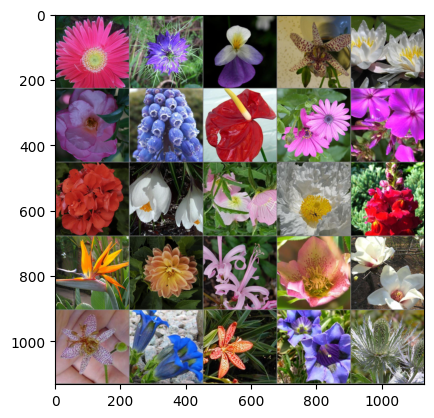

torch.Size([3, 224, 224])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Graph Visualisation Imports
#from torchviz import make_dot

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 100
batch_size = 32
learning_rate = 0.001




# Transforming images
transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),     # Converts to 224x224
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                            std=[0.5, 0.5, 0.5])])
                                      # Mean and S.D across all three colour channels, changing these numbers alters exposure

# Flower102: Unknown number and various sized color images in 102 classes, with 40 to 258 images per class
train_dataset = torchvision.datasets.Flowers102(root='./data', split='train',
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.Flowers102(root='./data', split='test',
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

def imshow(imgs):
    imgs = imgs / 2 + 0.5   # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

 #one batch of random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

print(images[0].size())

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 224, 3)     # In 3 channels, rest of params are changable
        self.pool = nn.MaxPool2d(2, 2)       # Inbetween convolutional layers, need max pooling and relu
        self.conv2 = nn.Conv2d(224, 152, 3)    # 32 output size, now 32 input size
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(152, 78, 3)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(78, 64, 3 )
        self.hidden = nn.Linear(64, 64, 3)
      
        
       
        self.fc1 = nn.Linear(210912, 64)    # 2 Linear layers to do classification at the end
        self.fc2 = nn.Linear(64, 102)      

    def forward(self, x):
        # N, 3, 32, 32          N is batch size, colour channels, image size
        x = F.relu(self.conv1(x))   # -> N, 32, 222, 222    #Apply activiation function to convolution directly instead of define in init
        x = self.pool(x)            # -> N, 32, 111, 111
        x = F.relu(self.conv2(x))   # -> N, 64, 109, 109
        x = self.pool(x)            # -> N, 64, 54, 54
        x = F.relu(self.conv3(x))   # -> N, 64, 52, 52
        x = torch.flatten(x, 1)     # -> N, 173056
        x = F.relu(self.fc1(x))     # -> N, 64
        x = self.fc2(x)             # -> N, 102
        return x


# Create model and push to device
model = ConvNet().to(device)

# Entropy loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Iterate over epochs and training loader
n_total_steps = len(train_loader)



while True:

    running_loss = 0.0
    
    
      

    for i, (images, labels) in enumerate(train_loader):
        # Push to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Need to clear gradient

        # Running loss
        running_loss += loss.item()


    # Divide by steps to get loss for epoch
    n = 0
    print(f'[{n}] loss: {running_loss / n_total_steps:.3f}')
    n = n + 1
    if running_loss / n_total_steps < 0.009:
      break

print('Finished Training')
PATH = './cnn.pth'
# Save model
torch.save(model.state_dict(), PATH)

[0] loss: 4.770
[0] loss: 4.556
[0] loss: 4.513
[0] loss: 4.419
[0] loss: 4.365
[0] loss: 4.282
[0] loss: 4.198
[0] loss: 4.101
[0] loss: 3.961
[0] loss: 3.831
[0] loss: 3.684
[0] loss: 3.577
[0] loss: 3.454
[0] loss: 3.363
[0] loss: 3.210
[0] loss: 2.984
[0] loss: 2.781
[0] loss: 2.528
[0] loss: 2.284
[0] loss: 2.052
[0] loss: 1.909
[0] loss: 1.742
[0] loss: 1.606
[0] loss: 1.406
[0] loss: 1.338
[0] loss: 1.101
[0] loss: 1.116
[0] loss: 1.048
[0] loss: 0.942
[0] loss: 0.823
[0] loss: 0.757
[0] loss: 0.816
[0] loss: 0.719
[0] loss: 0.726
[0] loss: 0.643
[0] loss: 0.609
[0] loss: 0.604
[0] loss: 0.518
[0] loss: 0.517
[0] loss: 0.470
[0] loss: 0.499
[0] loss: 0.581
[0] loss: 0.499
[0] loss: 0.466
[0] loss: 0.400
[0] loss: 0.449
[0] loss: 0.407
[0] loss: 0.374
[0] loss: 0.362
[0] loss: 0.371
[0] loss: 0.393
[0] loss: 0.327
[0] loss: 0.422
[0] loss: 0.395
[0] loss: 0.379
[0] loss: 0.379
[0] loss: 0.333
[0] loss: 0.369
[0] loss: 0.353
[0] loss: 0.347
[0] loss: 0.341
[0] loss: 0.361
[0] loss

In [ ]:
# Did not save model, so load model
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
# Push to device
loaded_model.to(device)
loaded_model.eval()

# Evaluation, no gradient required
with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:  # Iterate over test loader
        images = images.to(device)      # Push to GPU device
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)    # Compare outputs with lables
        n_correct += (predicted == labels).sum().item() # Number of correct

        outputs2 = loaded_model(images)       # Same put loaded model
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')